# Proyecto de Curso - Visualización de la Información

## Hipótesis

Las centrales termoeléctricas chilenas ubicadas en las llamadas “zonas de sacrificio” son ambientalmente agresivas por la contaminación en cuerpos de aguas superficiales (ríos, lagos, mar) según la Normativa Ambiental Vigente en Chile.

## Termoeléctricas

Nuestra fuente de datos proviene de la página web https://snifa.sma.gob.cl/DatosAbiertos, más específicamente del apartado RILES, el cual corresponde a una carpeta en Google Drive que contiene información entre los años 2017 al 2022, así como también un documento descriptivo en PDF que detalla los datos.
Nuestra principal motivación para realizar este análisis partió desde la revisión de noticias y eventos particulares que conllevan a un cese de operación de las termoeléctricas el cual no debe extenderse a más allá del año 2030, debido a la alta contaminación que existe con relación a estas. 

Lo primero es importar las librerías para cargar y manipular la información, además de realizar los gráficos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import geopandas as gpd
import folium
import warnings
import plotly.express as px

Cargamos la información de las termoeléctricas entre los años 2017 y 2022. En ella se encuentran las mediciones de Temperatura, Hierro Disuelto, Cobre, Molibdeno y Mercurio.

In [2]:
df_termoelectricas = pd.read_csv("../processed_data/data_termoelectricas.csv", sep = ";")

In [3]:
gdf = gpd.GeoDataFrame(df_termoelectricas, geometry = gpd.points_from_xy(df_termoelectricas["Longitud"], df_termoelectricas["Latitud"]))
gdf.shape

(3858, 13)

Creamos un mapa que tenga como punto de vista inicial Santiago. Luego importamos el polígono de los límites de Chile, el cual graficaremos encima del mapa para resaltarle al usuario el espacio de búsqueda.

In [4]:
f = folium.Figure(width=800, height=600)
map = folium.Map(location = [-33.37041450381538, -70.69793610926665], crs = "EPSG3857" ,zoom_start=3.5, tiles='OpenStreetMap').add_to(f)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
chile = world.loc[world['name'] == 'Chile']
sim_geo = gpd.GeoSeries(chile['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'orange'})
folium.Popup(chile["name"].values[0]).add_to(geo_j)
geo_j.add_to(map)

A partir de los nombres de las plantas buscamos sus coordenadas y crearemos un nuevo DataFrame que contenga esa información. Luego, graficaremos un marcador en el mapa en las coordenadas de todas las Termoeléctricas.

In [19]:
plantas = gdf["Planta"].unique() 
puntos = []
for planta in plantas:
    temp_gdf = gdf[gdf["Planta"] == planta]
    coords_planta = temp_gdf.iloc[0]["geometry"]
    puntos.append(coords_planta)
markers = pd.DataFrame({"Planta": plantas, "geometry": puntos})

for _, row in markers.iterrows():
    lat = row["geometry"].y
    lon = row["geometry"].x
    folium.Marker(location=[lat, lon],
                  popup=row["Planta"]).add_to(map)

map

## Panorama general del objeto de estudio

Es importante destacar que los hallazgos realizados en este estudio están en base a la Tabla 4 de la norma, esto quiere decir que se centra exclusivamente en descargas al mar dentro de la Zona de Protección Litoral (ZPL). Lo anterior se debe a que luego de filtrar los datos, apreciamos que todas las descargas que superaban los límites establecidos por la norma estaban asociados a cuerpos de agua marinos.

Se agrupan los datos para conocer los valores máximos reportados por cada planta y se convierte el GroupBy a DataFrame.

In [6]:
df_termoelectricas_filtrado = df_termoelectricas.groupby(["ANIO","MES","Parametro","CuerpoReceptor","Planta","Tabla","% diferencia_umbral"])["Valor reportado"].max()
df_termoelectricas_filtrado = df_termoelectricas_filtrado.to_frame()
df_termoelectricas_filtrado = df_termoelectricas_filtrado.reset_index()

Seleccionamos sólo los registros donde los valores de los parámetros superen los límites establecidos.

In [7]:
df_termoelectricas_filtrado = df_termoelectricas_filtrado.sort_values(by=['ANIO', 'MES',"Parametro","Tabla"])
df_termoelectricas_filtrado = df_termoelectricas_filtrado[['ANIO','MES',"Parametro","% diferencia_umbral","CuerpoReceptor","Planta","Tabla"]]
df_termoelectricas_filtrado = df_termoelectricas_filtrado[df_termoelectricas_filtrado["% diferencia_umbral"]>0]

Filtraremos sólo por la Tabla 4, correspondiente a descargas (Mar adentro ZPL), puesto que como se mencionó anteriormente, esta es la única que presenta valores que exceden los límites permitidos.\
Finalmente se organizan los datos para presentar un *Sunburst plot* con el resumen.

In [8]:
warnings.filterwarnings("ignore")

df_sunburst = df_termoelectricas_filtrado

df_sunburst=df_sunburst.reset_index()
for i in range(len(df_sunburst)):
    df_sunburst["Planta"][i]=df_sunburst["Planta"][i].replace("CENTRAL TERMOELÉCTRICA ","")
    df_sunburst["Planta"][i]=df_sunburst["Planta"][i].replace("CENTRAL TERMOELECTRICA ","")
    df_sunburst["Planta"][i]=df_sunburst["Planta"][i].replace("CENTRAL TERMICA ","")
    
    title = df_sunburst["Planta"][i].split()
    df_sunburst["Planta"][i]=title[0]+'<BR>'+' '.join(title[1:len(title)])
    
    title = df_sunburst["CuerpoReceptor"][i].split()
    df_sunburst["CuerpoReceptor"][i]=title[0]+'<BR>'+' '.join(title[1:len(title)])

In [9]:
warnings.filterwarnings("ignore")
    
fig = px.sunburst(df_sunburst, path=['ANIO','MES','Parametro','CuerpoReceptor','Planta',"% diferencia_umbral"], 
                  values='% diferencia_umbral',color='Parametro',width=800,height=800)

fig.update_traces(insidetextfont_color="white",insidetextorientation="radial", selector=dict(type='sunburst'))

fig.update_layout(title_text='CONTAMINANTES QUE SOBEREPASARON LOS LÍMITES PERMITIDOS<BR>ASOCIADOS A LAS DESCARGAS DE RESIDUOS LIQUIDOS A AGUAS MARINAS'
                  , title_x=0.5, title_y=0.98)         
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.add_annotation(x=0.5, y=0.57,
            text="Año",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=18
            )
fig.add_annotation(x=0.5, y=0.62,
            text="Mes",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )

fig.add_annotation(x=0.5, y=0.72,
            text="Contaminante",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )

fig.add_annotation(x=0.5, y=0.82,
            text="Cuerpo<BR>Receptor",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )

fig.add_annotation(x=0.5, y=0.89,
            text="Termoeléctrica",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )
fig.add_annotation(x=0.5, y=0.98,
            text="% Sobre el límite<BR>establecido",
            showarrow=False,
            arrowhead=1,
            font_color='white',
            font_size=20
            )
offset_y=-0.94

fig.add_annotation(x=0.03, y=0.99+offset_y,
            text="Límites establecidos",
            align="left",
            showarrow=False,
            font_color='black',
            font_size=12
            )

fig.add_annotation(x=0.03, y=0.96+offset_y,
            text="Molibedeno: 0.1 [mg/L]",
            align="left",
            showarrow=False,
            font_color='black',
            font_size=12
            )
fig.add_annotation(x=0.03, y=0.93+offset_y,
            text="Mercurio: 0.005 [mg/L]",
            align="left",
            showarrow=False,
            font_color='black',
            font_size=12
            )
fig.add_annotation(x=0.03, y=0.90+offset_y,
            text="Temperatura: 30 [°C]",
            align="left",
            showarrow=False,
            font_color='black',
            font_size=12
            )

fig.add_annotation(x=0, y=0.964+offset_y,
            text="██",
            align="left",
            showarrow=False,
            arrowhead=1,
            font_color='purple',
            font_size=12
            )
fig.add_annotation(x=0, y=0.934+offset_y,
            text="██",
            align="left",
            showarrow=False,
            arrowhead=1,
            font_color='green',
            font_size=12
            )
fig.add_annotation(x=0, y=0.904+offset_y,
            text="██",
            align="left",
            showarrow=False,
            arrowhead=1,
            font_color='red',
            font_size=12
            )
fig.show()

Impactos locales a causa de las termoeléctricas: Son todos aquellos que repercuten de manera directa sobre la población y los recursos naturales existentes en las zonas aledañas al lugar donde funciona una central. Entre estos destacan los impactos sobre recursos naturales, sobre otros sectores productivos y sobre la salud, que se ven afectadas ante cualquier superación de la norma como ocurre en lo expresado en el gráfico anterior.

## Temperatura

Se carga la información de datos de temperatura de todas las Termoeléctricas y se filtran los valores que se rigen por la Tabla 4.

In [10]:
temperaturas = pd.read_csv("../processed_data/temperatura.csv", sep = ";")
temperaturas_tabla4 = temperaturas[temperaturas["Tabla"] == "Tabla 4"].sort_values(by=["ANIO", "MES"]).reset_index()

Generamos una nueva columna con una marca temporal de la medición para poder graficar los valores de las mediciones en el tiempo.

In [11]:
fechas = []
for index, row in temperaturas_tabla4.iterrows():
    anio = str(temperaturas_tabla4.iloc[index]["ANIO"])
    if temperaturas_tabla4.iloc[index]["MES"] < 10:
        mes = "0" + str(temperaturas_tabla4.iloc[index]["MES"])
    else:
        mes = str(temperaturas_tabla4.iloc[index]["MES"])
    fecha = anio + "/" + mes
    fechas.append(fecha)
temperaturas_tabla4["FECHA"] = pd.Series(fechas)
temperaturas_tabla4["FECHA"] = temperaturas_tabla4["FECHA"].astype("datetime64")

El gráfico contiene las mediciones de todas las Termoeléctricas y destaca la que más excede el límite.

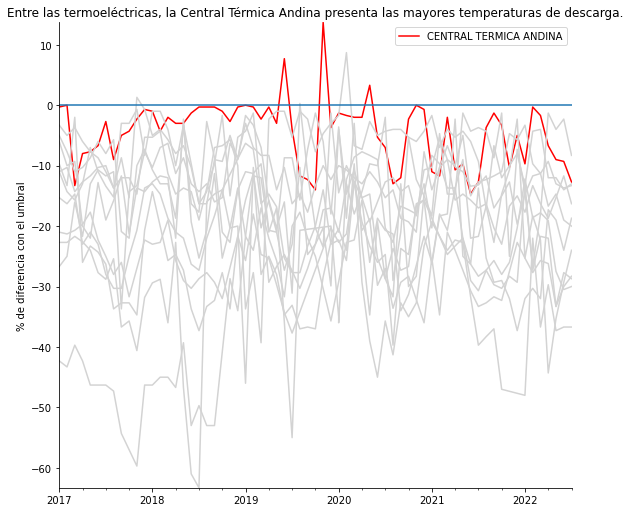

In [12]:
plantas = temperaturas_tabla4["Planta"].unique()

fig, ax = plt.subplots(1,1, figsize=(8,7))

for planta in plantas:
    df_planta = temperaturas_tabla4[temperaturas_tabla4["Planta"] == planta]
    color = 'red' if planta == 'CENTRAL TERMICA ANDINA' else 'lightgray'
    label = planta if planta == 'CENTRAL TERMICA ANDINA' else ''
    df_planta.plot(x='FECHA', y='% diferencia_umbral', color=color, ax=ax, legend=False, label = label)
ax.set_ylabel("% de diferencia con el umbral")
ax.set_xlabel("Fecha").set_visible(False)
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(y = 0)
ax.set_title("Entre las termoeléctricas, la Central Térmica Andina presenta las mayores temperaturas de descarga.")
ax.autoscale(enable = True, axis = "both", tight = True)
ax.legend()
plt.show()

Los procesos de generación termoeléctricos contemplan enfriamientos mediante el manejo de grandes volúmenes de agua que se captan principalmente desde el mar u otros cursos de agua naturales. 
Posteriormente la masa de agua es devuelta a una mayor temperatura (superando los 10 °C respecto a su temperatura de captación) y en un punto distinto al de captación, afectando a individuos, poblaciones y comunidades marinas, ya sea por la descarga de agua de enfriamiento o por vertimiento de contaminantes al ecosistema. Producto de que la masa de agua es devuelta a una temperatura mayor en relación con el cuerpo de agua receptor, dependiendo de la hidrodinámica de éste, se pueden generar plumas de aguas cálidas en la zona aledaña a la descarga, produciendo impactos biológicos significativos, tanto en el fondo marino -afectando a ciertas especies de invertebrados bentónicos-, como en la columna de agua. 

## Molibdeno

Se carga la información de datos de molibdeno de todas las Termoeléctricas y se filtran los valores que se rigen por la Tabla 4.

In [13]:
molibdeno = pd.read_csv("../processed_data/molibdeno.csv", sep = ";")
molibdeno_tabla4 = molibdeno[molibdeno["Tabla"] == "Tabla 4"].sort_values(by=["ANIO", "MES"]).reset_index()

Generamos una nueva columna con una marca temporal de la medición para poder graficar los valores de las mediciones en el tiempo.

In [14]:
fechas = []
for index, row in molibdeno_tabla4.iterrows():
    anio = str(molibdeno_tabla4.iloc[index]["ANIO"])
    if molibdeno_tabla4.iloc[index]["MES"] < 10:
        mes = "0" + str(molibdeno_tabla4.iloc[index]["MES"])
    else:
        mes = str(molibdeno_tabla4.iloc[index]["MES"])
    fecha = anio + "/" + mes
    fechas.append(fecha)
molibdeno_tabla4["FECHA"] = pd.Series(fechas)
molibdeno_tabla4["FECHA"] = molibdeno_tabla4["FECHA"].astype("datetime64")

El gráfico contiene las mediciones de todas las Termoeléctricas y destaca la que más excede el límite.

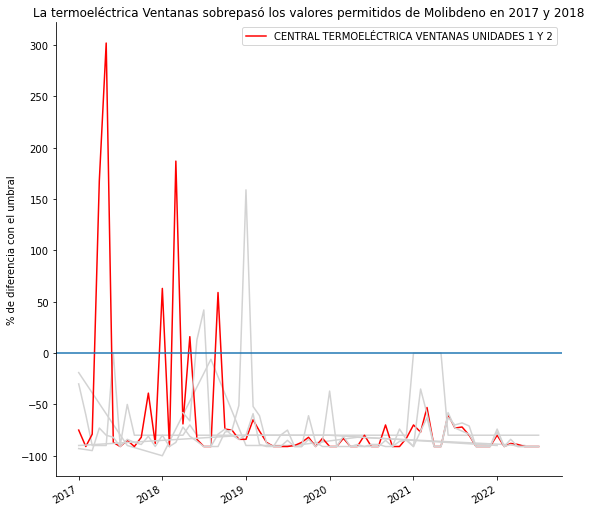

In [15]:
plantas = molibdeno_tabla4["Planta"].unique()

fig, ax = plt.subplots(1,1, figsize=(8,7))

for planta in plantas:
    df_planta = molibdeno_tabla4[molibdeno_tabla4["Planta"] == planta]
    color = 'red' if planta == 'CENTRAL TERMOELÉCTRICA VENTANAS UNIDADES 1 Y 2' else 'lightgray'
    label = planta if planta == 'CENTRAL TERMOELÉCTRICA VENTANAS UNIDADES 1 Y 2' else ''
    df_planta.plot(x='FECHA', y='% diferencia_umbral', color=color, ax=ax, legend=False, label = label)
ax.set_ylabel("% de diferencia con el umbral")
ax.set_xlabel("Fecha").set_visible(False)
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(y = 0)
ax.set_title("La termoeléctrica Ventanas sobrepasó los valores permitidos de Molibdeno en 2017 y 2018")
ax.legend()
plt.show()

La concentración de metales pesados como lo es el aluminio, **molibdeno**, hierro, cromo, cobre y cinc, han producido una contaminación marina importante, la cual, en cifras excede los límites permitidos por las pautas de calidad internacionales y que a la fecha no han podido ser debidamente reguladas por nuestra normativa ambiental (https://capes.cl/2020/11/estudio-determino-los-efectos-de-la-contaminacion-por-metales-en-poblaciones-de-huiro-negro-2/).
La población de algas de Ventanas expuesta crónicamente a la contaminación vio disminuir el tamaño de sus individuos adultos en comparación con las poblaciones de las otras zonas afectadas. Siendo la localidad de Ventanas la que percibe las consecuencias más negativas de la contaminación para el desarrollo de los individuos de la especie, lo que sugiere un impacto negativo a largo plazo en la estructura comunitaria de estas zonas marinas y pondrá en peligro la salud del ecosistema marino incluso en sitios alejados de la fuente de contaminación.

## Mercurio

Se carga la información de datos de mercurio de todas las Termoeléctricas y se filtran los valores que se rigen por la Tabla 4.

In [16]:
mercurio = pd.read_csv("../processed_data/mercurio.csv", sep = ";")
mercurio_tabla4 = mercurio[mercurio["Tabla"] == "Tabla 4"].sort_values(by=["ANIO", "MES"]).reset_index()

Generamos una nueva columna con una marca temporal de la medición para poder graficar los valores de las mediciones en el tiempo.

In [17]:
fechas = []
for index, row in mercurio_tabla4.iterrows():
    anio = str(mercurio_tabla4.iloc[index]["ANIO"])
    if mercurio_tabla4.iloc[index]["MES"] < 10:
        mes = "0" + str(mercurio_tabla4.iloc[index]["MES"])
    else:
        mes = str(mercurio_tabla4.iloc[index]["MES"])
    fecha = anio + "/" + mes
    fechas.append(fecha)
mercurio_tabla4["FECHA"] = pd.Series(fechas)
mercurio_tabla4["FECHA"] = mercurio_tabla4["FECHA"].astype("datetime64")

El gráfico contiene las mediciones de todas las Termoeléctricas y destaca la que más excede el límite.

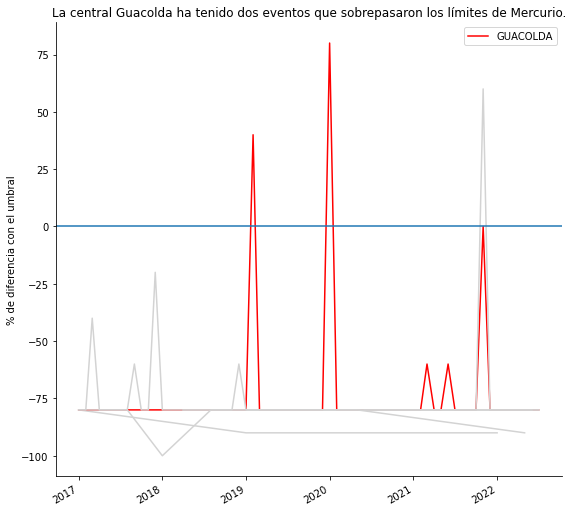

In [18]:
plantas = mercurio_tabla4["Planta"].unique()

fig, ax = plt.subplots(1,1, figsize=(8,7))

for planta in plantas:
    df_planta = mercurio_tabla4[mercurio_tabla4["Planta"] == planta]
    color = 'red' if planta == 'GUACOLDA' else 'lightgray'
    label = planta if planta == 'GUACOLDA' else ''
    df_planta.plot(x='FECHA', y='% diferencia_umbral', color=color, ax=ax, legend=False, label = label)
ax.set_ylabel("% de diferencia con el umbral")
ax.set_xlabel("Fecha").set_visible(False)
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(y = 0)
ax.set_title("La central Guacolda ha tenido dos eventos que sobrepasaron los límites de Mercurio.")
ax.legend()
plt.show()

De acuerdo a lo observado, en la provincia del Huasco, Región de Atacama, se encuentra operativa la Central Guacolda, que de acuerdo a la información, superan los niveles de Mercurio en un 40% y 80% para los límites máximos en los años 2019 y 2020 respectivamente.
Sumado a lo anterior, según el Observatorio Latinoamericano de Conflictos Ambientales de publicación del año 2020, en estudios realizados a mujeres en la comuna del Huasco, se encontró que un 53% de las mujeres estudiadas presentaron altas concentraciones de mercurio por sobre los 0.58 ppm, lo peor, es que un 18% marcó sobre 1 una partícula por millón, que es la barrera donde se podrían presentar daños cerebrales, pérdida de coeficiente intelectual y otras enfermedades.
Dicha exposición al mercurio también perjudica a los niños, ya que la exposición en edades tempranas e incluso desde su formación en el útero va a determinar algunas enfermedades crónicas a lo largo de su vida como por ejemplo diferentes tipos de discapacidad tanto intelectual como motora, o personas con autismo.


## Conclusiones

-	De acuerdo a lo observado, es posible evidenciar que se ha superado la normativa ambiental vigente en varias oportunidades entre los años 2017 a 2019 para varias instalaciones, esto para descargas puntuales asociadas a concentraciones sobre lo permitido para Mercurio, Molibdeno y Temperatura. En base a esto, se puede decir que la actividad económica es ambientalmente agresiva debido a que solo dentro del alcance de este proyecto se han analizado 5 parámetros, encontrándose alteraciones en 3 de ellos, es decir, si en un universo de 42 parámetros que regula la norma solo en 5 ya se encontraron desviaciones importantes, es altamente probable que para otros parámetros la situación sea similar. Esto último sumado a los efectos de Daño Ambiental mencionados como parte del trabajo refuerzan la hipótesis planteada al comienzo del trabajo.
-	Las termoeléctricas ubicadas en las Costas Chilenas, impactan significativamente los ecosistemas marinos y las actividades económicas locales y comunitarias asociadas, desarrolladas tradicionalmente por sus habitantes Esto debido a efectos nocivos provocado por la bioacumulación por metales pesados que se han descrito en etapas anteriores de este trabajo.
-	Chile ha comprometido en el marco de su “Contribución Nacional para el Acuerdo Climático de París de 2015”, reducir sus emisiones de Gases Efecto Invernadero (GEI) en un 30% por unidad de Producto Interno Bruto (PIB) al año 2030, con respecto al año 2007. (ttps://energia.gob.cl/noticias/aysen-del-general-carlos-ibanez-del-campo/plan-de-descarbonizacion-proceso-historico-para-chile). Existe la intención de descarbonizar la matriz energética en el mediano plazo, por lo que se avanza, a nivel de compromiso, en el cierre de 8 centrales termoeléctricas, las de mayor antigüedad, al año 2024. 